Define path and decompression pseudo tag

In [ ]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import random
import math # for EAR calculation

# --- Clean up old pseudo-labels and zip archives (if generated in /kaggle/working/ previously) ---
# This step ensures a clean state upon each Notebook run, removing any temporary old pseudo-labels
PSEUDO_LABELS_ROOT_TEMP = '/kaggle/working/yolo_pseudo_labels/'
PSEUDO_LABELS_TARGZ_TEMP = '/kaggle/working/output/yolo_pseudo_labels_packed.tar.gz' 

if os.path.exists(PSEUDO_LABELS_ROOT_TEMP):
    print(f"Removing old pseudo-labels directory: {PSEUDO_LABELS_ROOT_TEMP}")
    !rm -rf "{PSEUDO_LABELS_ROOT_TEMP}"

if os.path.exists(PSEUDO_LABELS_TARGZ_TEMP):
    print(f"Removing old pseudo-labels zip: {PSEUDO_LABELS_TARGZ_TEMP}")
    !rm -f "{PSEUDO_LABELS_TARGZ_TEMP}"

print("\nEnvironment cleaned: old temporary pseudo-labels removed.")


# --- Configuration Paths ---
# Original dataset root path (consistent with previous confirmation)
ORIGINAL_DATASET_SLUG = "v2-cam1-cam2-split-by-driver"
ORIGINAL_DATASET_ROOT = f"/kaggle/input/{ORIGINAL_DATASET_SLUG}/v2_cam1_cam2_split_by_driver/"

# Pseudo-labels dataset slug (confirmed from your Kaggle Input list)
PSEUDO_LABELS_DATASET_SLUG = "yolo-pseudo-labels"
# Final pseudo-labels root (directly points to the already extracted root, as confirmed by your Input structure)
FINAL_PSEUDO_LABELS_ROOT = f"/kaggle/input/{PSEUDO_LABELS_DATASET_SLUG}/"

# PSEUDO_LABELS_INPUT_PATH and PSEUDO_LABELS_ZIP_NAME are no longer needed as the archive is auto-extracted by Kaggle

# --- Dataset subdirectory structure ---
SUB_DIRS = [
    'Camera 1/train', 'Camera 1/test', 'Camera 2/train', 'Camera 2/test',
]

# --- COCO ID to Name Mapping ---
COCO_ID_TO_NAME = {
    0: 'person', 39: 'bottle', 41: 'cup', 67: 'cell phone',
}

print("Configuration loaded.")
print(f"Original Dataset root: {ORIGINAL_DATASET_ROOT}")
print(f"Final pseudo-labels root (already extracted): {FINAL_PSEUDO_LABELS_ROOT}")


Environment cleaned: old temporary pseudo-labels removed.
Configuration loaded.
Original Dataset root: /kaggle/input/v2-cam1-cam2-split-by-driver/v2_cam1_cam2_split_by_driver/
Final pseudo-labels root (already extracted): /kaggle/input/yolo-pseudo-labels/


安装 MediaPipe (用于人脸关键点和姿态估计)

In [2]:
print("\nInstalling MediaPipe...")
!pip install mediapipe
print("MediaPipe installed.")


Installing MediaPipe...
INFO: pip is looking at multiple versions of opencv-contrib-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 28.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.12.0.88
    Uninstalling opencv-contrib-python-4.12.0.88:
      Successfully uninstalled opencv-contrib-python-4.12.0.88
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0

特征提取与特征向量构建

In [ ]:
import mediapipe as mp
import math
import numpy as np
import cv2
import pandas as pd
import os
import glob
import random

# Initialize MediaPipe for face detection and pose estimation
mp_face_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils
drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)

all_features = []
all_labels = [] # Original c0-c9 category labels

# --- EAR (Eye Aspect Ratio) Auxiliary function for calculation ---
LEFT_EYE_INDICES = [362, 385, 387, 263, 373, 380]
RIGHT_EYE_INDICES = [33, 159, 158, 133, 153, 145]

def euclidean_distance(point1_norm, point2_norm, img_w, img_h):
    # Convert normalized coordinates to pixel coordinates before calculating distance.
    p1_x, p1_y = point1_norm.x * img_w, point1_norm.y * img_h
    p2_x, p2_y = point2_norm.x * img_w, point2_norm.y * img_h
    return math.sqrt((p1_x - p2_x)**2 + (p1_y - p2_y)**2) # 修正 p2.y -> p2_y

def calculate_ear(landmarks, eye_indices, img_w, img_h):
    if not landmarks:
        return 0.0

    p1 = landmarks.landmark[eye_indices[0]]
    p4 = landmarks.landmark[eye_indices[3]]
    p2 = landmarks.landmark[eye_indices[1]]
    p3 = landmarks.landmark[eye_indices[2]]
    p5 = landmarks.landmark[eye_indices[4]]
    p6 = landmarks.landmark[eye_indices[5]]

    v1 = euclidean_distance(p2, p6, img_w, img_h)
    v2 = euclidean_distance(p3, p5, img_w, img_h)
    h = euclidean_distance(p1, p4, img_w, img_h)

    if h == 0:
        return 0.0

    ear = (v1 + v2) / (2.0 * h)
    return ear

# --- Convert normalized coordinates to pixel coordinates (YOLO tag) ---
def xywhn2xyxy(x_center, y_center, width, height, img_w, img_h):
    xmin = int((x_center - width / 2) * img_w)
    ymin = int((y_center - height / 2) * img_h)
    xmax = int((x_center + width / 2) * img_w)
    ymax = int((y_center + height / 2) * img_h)
    return xmin, ymin, xmax, ymax

# --- Calculate head pose (Pitch, Yaw, Roll) ---
MODEL_3D_POINTS = np.array([
    (0.0, 0.0, 0.0),
    (-225.0, 170.0, -135.0),
    (225.0, 170.0, -135.0),
    (-150.0, -150.0, -125.0),
    (150.0, -150.0, -125.0),
    (0.0, -330.0, -65.0)
], dtype="double")

MEDIAPIPE_POINTS_INDICES = [1, 263, 33, 61, 291, 152]

def calculate_head_pose(landmarks, img_w, img_h):
    if not landmarks:
        return 0.0, 0.0, 0.0

    image_points = np.array([
        (landmarks.landmark[idx].x * img_w, landmarks.landmark[idx].y * img_h)
        for idx in MEDIAPIPE_POINTS_INDICES
    ], dtype="double")

    focal_length = img_w
    center = (img_w / 2, img_h / 2)
    camera_matrix = np.array([
        [focal_length, 0, center[0]],
        [0, focal_length, center[1]],
        [0, 0, 1]
    ], dtype="double")
    dist_coeffs = np.zeros((4, 1))

    success, rotation_vector, translation_vector = cv2.solvePnP(
        MODEL_3D_POINTS, image_points, camera_matrix, dist_coeffs, flags=cv2.SOLVEPNP_ITERATIVE
    )

    if not success:
        return 0.0, 0.0, 0.0

    rmat, _ = cv2.Rodrigues(rotation_vector)

    try:
        sy = math.sqrt(rmat[0,0] * rmat[0,0] + rmat[1,0] * rmat[1,0])
        singular = sy < 1e-6

        if not singular:
            x = math.atan2(rmat[2,1], rmat[2,2])
            y = math.atan2(-rmat[2,0], sy)
            z = math.atan2(rmat[1,0], rmat[0,0])
        else:
            x = math.atan2(-rmat[1,2], rmat[1,1])
            y = math.atan2(-rmat[2,0], sy)
            z = 0

        pitch = math.degrees(x)
        yaw = math.degrees(y)
        roll = math.degrees(z)
        return pitch, yaw, roll
    except Exception as e:
        print(f"  - Error calculating Euler angles: {e}. Returning default pose.")
        return 0.0, 0.0, 0.0

# Initialize MediaPipe for face detection and pose estimation
mp_face_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils
drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)

# Feature list
all_features = []
all_labels = []

# --- Main loop: Iterate through the images and extract features ---
if FINAL_PSEUDO_LABELS_ROOT:
    print("\nStarting feature extraction...")
    with mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True, min_detection_confidence=0.5) as face_mesh:
        for sub_dir in SUB_DIRS:
            image_sub_dir = os.path.join(ORIGINAL_DATASET_ROOT, sub_dir)
            label_sub_dir = os.path.join(FINAL_PSEUDO_LABELS_ROOT, sub_dir)

            for i in range(10):
                class_folder = f"c{i}"
                image_class_dir = os.path.join(image_sub_dir, class_folder)
                label_class_dir = os.path.join(label_sub_dir, class_folder)

                image_files = glob.glob(os.path.join(image_class_dir, '*.jpg'))
                if not image_files:
                    continue

                print(f"  - Extracting features from {len(image_files)} images in {os.path.join(sub_dir, class_folder)}...")

                for img_path in image_files:
                    base_name = os.path.basename(img_path)
                    label_file = os.path.join(label_class_dir, base_name.replace('.jpg', '.txt'))

                    if not os.path.exists(label_file):
                        continue

                    img_orig = cv2.imread(img_path)
                    if img_orig is None:
                        print(f"    - Error: Could not read image {img_path}. Skipping.")
                        continue
                    
                    img_h, img_w, _ = img_orig.shape
                    
                    yolo_labels = []
                    with open(label_file, 'r') as f:
                        for line in f.readlines():
                            parts = line.strip().split(' ')
                            if len(parts) == 5:
                                yolo_labels.append([int(parts[0])] + list(map(float, parts[1:])))
                    
                    feature_vector = {
                        'original_class': i,
                        'has_person': 0,
                        'person_bbox_xmin': -1, 'person_bbox_ymin': -1, 'person_bbox_xmax': -1, 'person_bbox_ymax': -1,
                        'has_cell_phone': 0,
                        'cell_phone_bbox_xmin': -1, 'cell_phone_bbox_ymin': -1, 'cell_phone_bbox_xmax': -1, 'cell_phone_bbox_ymax': -1,
                        'has_bottle': 0,
                        'bottle_bbox_xmin': -1, 'bottle_bbox_ymin': -1, 'bottle_bbox_xmax': -1, 'bottle_bbox_ymax': -1,
                        'head_pitch': 0.0, 'head_yaw': 0.0, 'head_roll': 0.0,
                        'ear_left': 0.0, 'ear_right': 0.0,
                    }

                    person_bbox = None
                    for label_info in yolo_labels:
                        cls_id = label_info[0]
                        x_center, y_center, width, height = label_info[1:]
                        
                        xmin, ymin, xmax, ymax = xywhn2xyxy(x_center, y_center, width, height, img_w, img_h)

                        if cls_id == 0: # person
                            feature_vector['has_person'] = 1
                            feature_vector['person_bbox_xmin'] = xmin
                            feature_vector['person_bbox_ymin'] = ymin
                            feature_vector['person_bbox_xmax'] = xmax
                            feature_vector['person_bbox_ymax'] = ymax
                            person_bbox = (xmin, ymin, xmax, ymax)
                        elif cls_id == 67: # cell phone
                            feature_vector['has_cell_phone'] = 1
                            feature_vector['cell_phone_bbox_xmin'] = xmin
                            feature_vector['cell_phone_bbox_ymin'] = ymin
                            feature_vector['cell_phone_bbox_xmax'] = xmax
                            feature_vector['cell_phone_bbox_ymax'] = ymax
                        elif cls_id == 39: # bottle
                            feature_vector['has_bottle'] = 1
                            feature_vector['bottle_bbox_xmin'] = xmin
                            feature_vector['bottle_bbox_ymin'] = ymin
                            feature_vector['bottle_bbox_xmax'] = xmax
                            feature_vector['bottle_bbox_ymax'] = ymax
                        elif cls_id == 41: # cup
                             feature_vector['has_bottle'] = 1
                    
                    if feature_vector['has_person'] == 1 and person_bbox:
                        img_rgb = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
                        results_mp = face_mesh.process(img_rgb)

                        if results_mp.multi_face_landmarks:
                            face_landmarks = results_mp.multi_face_landmarks[0] 
                            
                            feature_vector['ear_left'] = calculate_ear(face_landmarks, LEFT_EYE_INDICES, img_w, img_h)
                            feature_vector['ear_right'] = calculate_ear(face_landmarks, RIGHT_EYE_INDICES, img_w, img_h)

                            pitch, yaw, roll = calculate_head_pose(face_landmarks, img_w, img_h)
                            feature_vector['head_pitch'] = pitch
                            feature_vector['head_yaw'] = yaw
                            feature_vector['head_roll'] = roll

                    all_features.append(feature_vector)
                    all_labels.append(i)

    print("\nFeature extraction complete!")
    print(f"Extracted features for {len(all_features)} images.")

    features_df = pd.DataFrame(all_features)
    labels_df = pd.DataFrame(all_labels, columns=['class_id'])

    features_output_path = '/kaggle/working/output/extracted_features.csv'
    labels_output_path = '/kaggle/working/output/image_labels.csv'

    os.makedirs(os.path.dirname(features_output_path), exist_ok=True)
    features_df.to_csv(features_output_path, index=False)
    labels_df.to_csv(labels_output_path, index=False)

    print(f"\nExtracted features saved to: {features_output_path}")
    print(f"Original image labels saved to: {labels_output_path}")
    print("Remember to 'Save Version' of your Notebook to persist these files.")

else:
    print("Skipping feature extraction as pseudo-labels root is invalid.")

2025-12-02 21:53:02.194390: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764712382.650280      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764712382.808844      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered



Starting feature extraction...
  - Extracting features from 2440 images in Camera 1/train/c0...


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1764712401.592938      73 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764712401.614459      74 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764712401.774679      73 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


  - Extracting features from 1305 images in Camera 1/train/c1...
  - Extracting features from 862 images in Camera 1/train/c2...
  - Extracting features from 744 images in Camera 1/train/c3...
  - Extracting features from 950 images in Camera 1/train/c4...
  - Extracting features from 753 images in Camera 1/train/c5...
  - Extracting features from 733 images in Camera 1/train/c6...
  - Extracting features from 691 images in Camera 1/train/c7...
  - Extracting features from 698 images in Camera 1/train/c8...
  - Extracting features from 1379 images in Camera 1/train/c9...
  - Extracting features from 266 images in Camera 1/test/c0...
  - Extracting features from 133 images in Camera 1/test/c1...
  - Extracting features from 114 images in Camera 1/test/c2...
  - Extracting features from 100 images in Camera 1/test/c3...
  - Extracting features from 90 images in Camera 1/test/c4...
  - Extracting features from 90 images in Camera 1/test/c5...
  - Extracting features from 63 images in Came

最终分类器的训练

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import os
import matplotlib.pyplot as plt # Import matplotlib for plotting
import seaborn as sns # Import seaborn for enhanced plots



# if 'FINAL_PSEUDO_LABELS_ROOT' in locals() and FINAL_PSEUDO_LABELS_ROOT:
print("\n--- Starting final classifier training ---")

# 1. Load Features and Labels
features_output_path = '/kaggle/working/output/extracted_features.csv'
labels_output_path = '/kaggle/working/output/image_labels.csv'

# Check if feature and label CSV files exist
if not os.path.exists(features_output_path) or not os.path.exists(labels_output_path):
    print(f"Error: Feature or label CSV files not found. Expected at {features_output_path} and {labels_output_path}")
    print("Please ensure the previous feature extraction step completed successfully.")
else:
    features_df = pd.read_csv(features_output_path)
    labels_df = pd.read_csv(labels_output_path)

    # X should be all columns of features_df except 'original_class'
    # y should be the 'class_id' from labels_df
    X = features_df.drop(columns=['original_class']).values # Feature data, 'original_class' column removed
    y = labels_df['class_id'].values # Class labels

    # 2. Split Data: Training, Validation, Test Sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp) # 15% val, 15% test

    print(f"Total samples: {len(X)}")
    print(f"Train samples: {len(X_train)}, Validation samples: {len(X_val)}, Test samples: {len(X_test)}")

    # 3. Feature Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # --- EAR (Eye Aspect Ratio) Analysis ---
    ORIGINAL_CLASS_NAMES = {
        0: 'c0 (Safe Driving)', 1: 'c1 (Texting Right)', 2: 'c2 (Talk Right)',
        3: 'c3 (Texting Left)', 4: 'c4 (Talk Left)', 5: 'c5 (Adjust Radio)',
        6: 'c6 (Drinking)', 7: 'c7 (Reach Behind)', 8: 'c8 (Hair & Makeup)',
        9: 'c9 (Look Away)',
    }
    
    print("\n--- EAR (Eye Aspect Ratio) Analysis ---")
    # Filter out samples where person might not be detected or EAR is 0.0 (default failure)
    ear_analysis_df = features_df[(features_df['has_person'] == 1) & (features_df['ear_left'] != 0.0) & (features_df['ear_right'] != 0.0)].copy()

    if not ear_analysis_df.empty:
        # Calculate EAR mean and standard deviation per class
        ear_stats = ear_analysis_df.groupby('original_class')[['ear_left', 'ear_right']].agg(['mean', 'std'])
        print("\nEAR Mean and Standard Deviation per Class (excluding 0.0 defaults):")
        print(ear_stats)

        # Plot EAR Distribution (Histograms/KDE)
        plt.figure(figsize=(14, 6))
        plt.subplot(1, 2, 1)
        sns.histplot(ear_analysis_df['ear_left'], kde=True, bins=30, color='skyblue')
        plt.title('Distribution of Left EAR')
        plt.xlabel('EAR Value')
        plt.ylabel('Frequency')

        plt.subplot(1, 2, 2)
        sns.histplot(ear_analysis_df['ear_right'], kde=True, bins=30, color='lightcoral')
        plt.title('Distribution of Right EAR')
        plt.xlabel('EAR Value')
        plt.ylabel('Frequency')
        plt.tight_layout()
        plt.show()

        # Plot EAR Mean per Class (Box plots)
        plt.figure(figsize=(14, 7))
        sns.boxplot(x='original_class', y='ear_left', data=ear_analysis_df, palette='viridis')
        plt.title('Left EAR Distribution Across Distraction Classes')
        plt.xlabel('Distraction Class ID')
        plt.ylabel('Left EAR Value')
        plt.xticks(
            list(ORIGINAL_CLASS_NAMES.keys()),
            list(ORIGINAL_CLASS_NAMES.values()),
            rotation=45, ha='right'
        )
        plt.tight_layout()
        plt.show()
        
        plt.figure(figsize=(14, 7))
        sns.boxplot(x='original_class', y='ear_right', data=ear_analysis_df, palette='viridis')
        plt.title('Right EAR Distribution Across Distraction Classes')
        plt.xlabel('Distraction Class ID')
        plt.ylabel('Right EAR Value')
        plt.xticks(
            list(ORIGINAL_CLASS_NAMES.keys()),
            list(ORIGINAL_CLASS_NAMES.values()),
            rotation=45, ha='right'
        )
        plt.tight_layout()
        plt.show()
    else:
        print("No valid EAR data found for analysis after filtering 0.0 default values.")


    # 4. Build a simple Neural Network Classifier (using Keras)
    num_classes = 10 # c0-c9
    input_dim = X_train_scaled.shape[1] # Dimension of the feature vector

    model_classifier = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='relu'), # First hidden layer
        layers.Dropout(0.3), # Dropout for regularization
        layers.Dense(64, activation='relu'), # Second hidden layer
        layers.Dropout(0.3), # Dropout for regularization
        layers.Dense(num_classes, activation='softmax') # Output layer, Softmax for multi-class classification
    ])

    model_classifier.compile(optimizer='adam', # Optimizer: Adam
                            loss='sparse_categorical_crossentropy', # Loss function: suitable for integer labels in multi-class problems
                            metrics=['accuracy']) # Evaluation metric: Accuracy

    print("\nClassifier Model Summary:")
    model_classifier.summary()

    # 5. Train the Model
    print("\nTraining classifier...")
    history = model_classifier.fit(X_train_scaled, y_train,
                                   epochs=15, # Changed epochs from 30 to 15 as requested
                                   batch_size=32,
                                   validation_data=(X_val_scaled, y_val), # Evaluate performance on validation set
                                   verbose=1) # Display training progress

    # --- Visualize Training History ---
    plt.figure(figsize=(14, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy History')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # 6. Evaluate the Model
    print("\nEvaluating final classifier on the test set:")
    y_pred_probs = model_classifier.predict(X_test_scaled, verbose=0) # Added verbose=0 for cleaner output
    y_pred = np.argmax(y_pred_probs, axis=-1)
    
    print(f"Accuracy on test set: {accuracy_score(y_test, y_pred):.4f}")
    
    print("\nClassification Report:")
    target_names = [f'c{i}' for i in range(num_classes)]
    print(classification_report(y_test, y_pred, target_names=target_names))

    # --- Visualize Confusion Matrix ---
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # --- Visualize Precision, Recall, F1-score per Class ---
    report_dict = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
    
    metrics_df = pd.DataFrame()
    for class_name, metrics in report_dict.items():
        if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
            metrics_df = pd.concat([metrics_df, pd.DataFrame([metrics], index=[class_name])])
    
    metrics_df = metrics_df[['precision', 'recall', 'f1-score']]

    metrics_df.plot(kind='bar', figsize=(14, 7), rot=45)
    plt.title('Precision, Recall, and F1-score per Class')
    plt.xlabel('Class')
    plt.ylabel('Score')
    plt.legend(loc='lower right')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


    # --- Save the Trained Classifier Model ---
    os.makedirs(os.path.dirname(CLASSIFIER_MODEL_PATH), exist_ok=True) # Ensure output directory exists
    model_classifier.save(CLASSIFIER_MODEL_PATH)
    print(f"\nFinal classifier model saved to: {CLASSIFIER_MODEL_PATH}")
    print("Model saved to local directory.") # Updated message for local


--- Starting final classifier training ---
Total samples: 14478
Train samples: 10134, Validation samples: 2172, Test samples: 2172


I0000 00:00:1764712940.328164      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1764712940.328934      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5



Classifier Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,594 (45.29 KB)

 Trainable params: 11,594 (45.29 KB)

 Non-trainable params: 0 (0.00 B)


Training classifier...
Epoch 1/30


I0000 00:00:1764712943.224143      92 service.cc:148] XLA service 0x7a4fdc00c000 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764712943.225208      92 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1764712943.225226      92 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1764712943.540600      92 cuda_dnn.cc:529] Loaded cuDNN version 90300


 77/317 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1762 - loss: 2.3267

I0000 00:00:1764712945.199131      92 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


317/317 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.2442 - loss: 2.1880 - val_accuracy: 0.3568 - val_loss: 1.8667
Epoch 2/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3203 - loss: 1.9303 - val_accuracy: 0.3932 - val_loss: 1.7666
Epoch 3/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3710 - loss: 1.8049 - val_accuracy: 0.4171 - val_loss: 1.7157
Epoch 4/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3801 - loss: 1.7757 - val_accuracy: 0.4222 - val_loss: 1.6743
Epoch 5/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3861 - loss: 1.7348 - val_accuracy: 0.4305 - val_loss: 1.6458
Epoch 6/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4061 - loss: 1.6971 - val_accuracy: 0.4429 - val_loss: 1.6177
Epoch 7/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4073 - loss: 1.6938 - val_accuracy: 0.4540 - val_loss: 1.6066
Epoch 8/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4056 - loss: 1.6832 - val_accuracy: 0.4397 - val_

Accuracy on test set: 0.4913

Classification Report:
              precision    recall  f1-score   support

          c0       0.42      0.82      0.56       448
          c1       0.37      0.53      0.44       258
          c2       0.32      0.40      0.36       188
          c3       0.83      0.12      0.21       168
          c4       0.84      0.13      0.23       198
          c5       0.61      0.64      0.63       169
          c6       0.37      0.19      0.25       162
          c7       0.77      0.30      0.43       155
          c8       0.38      0.10      0.15       157
          c9       0.84      0.90      0.87       269

    accuracy                           0.49      2172
   macro avg       0.57      0.41      0.41      2172
weighted avg       0.56      0.49      0.45      2172


Final classifier model saved to: /kaggle/working/output/final_classifier_model.h5
Remember to 'Save Version' of your Notebook to persist these files.


## train again with more output imformation


--- Starting final classifier training ---
Loading features from: c:\project\pattern recognition and neural network\extracted_features.csv
Total samples: 14478
Train samples: 10134, Validation samples: 2172, Test samples: 2172

--- EAR (Eye Aspect Ratio) Analysis ---

EAR Mean and Standard Deviation per Class (excluding 0.0 defaults):
                ear_left           ear_right          
                    mean       std      mean       std
original_class                                        
0               0.805328  0.458326  0.234106  0.117585
1               0.772831  0.414353  0.181829  0.078133
2               0.259017  0.157524  0.490476  0.217356
3               0.489124  0.401833  0.391658  0.230019
4               0.734475  0.414262  0.233476  0.098479
5               0.628960  0.337333  0.225916  0.171999
6               0.724746  0.530793  0.243308  0.137375
7               0.350127  0.351589  0.260960  0.157233
8               0.584369  0.332931  0.316093  0.164273
9 

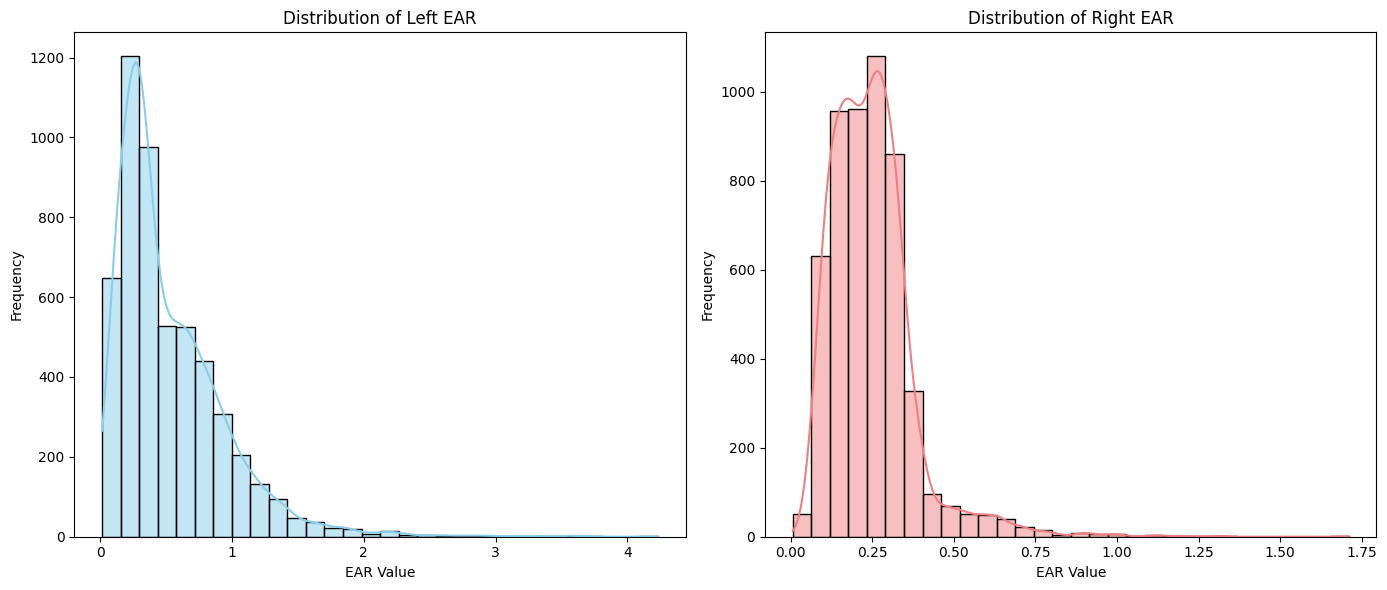

C:\Users\15059\AppData\Local\Temp\ipykernel_22268\399123161.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='original_class', y='ear_left', data=ear_analysis_df, palette='viridis')


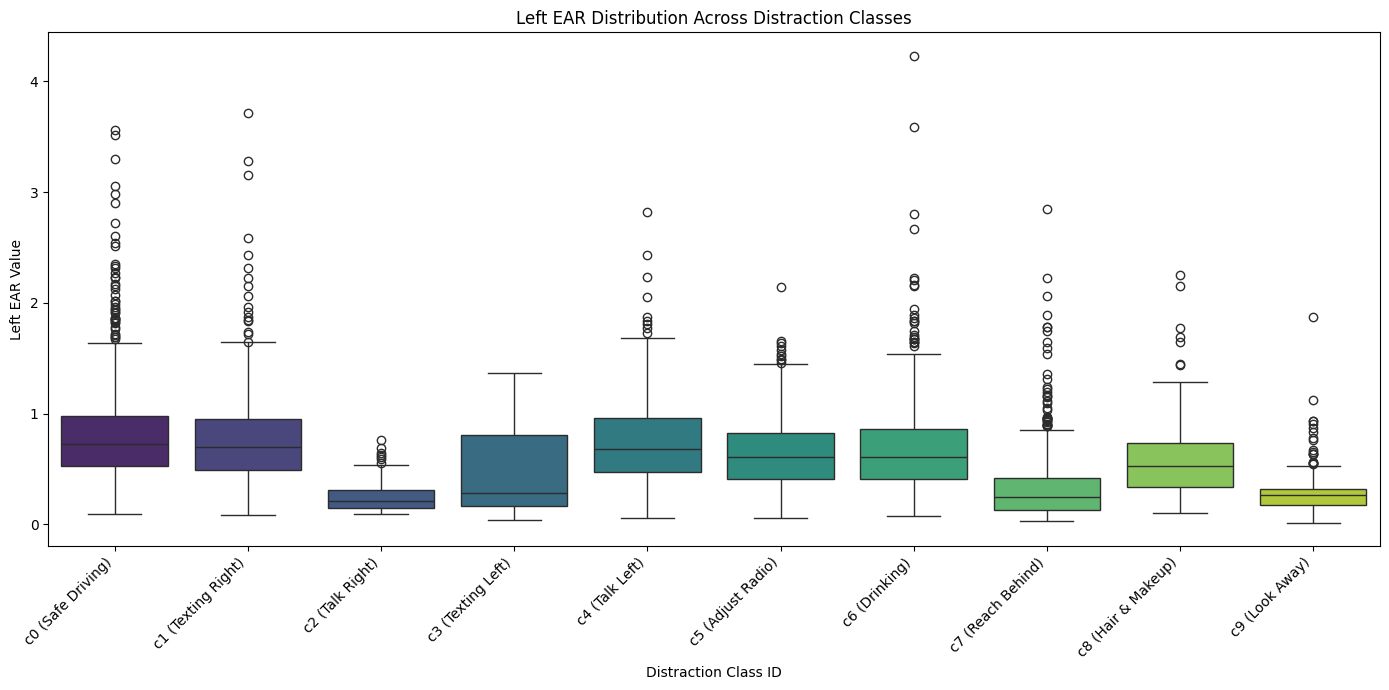

C:\Users\15059\AppData\Local\Temp\ipykernel_22268\399123161.py:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='original_class', y='ear_right', data=ear_analysis_df, palette='viridis')


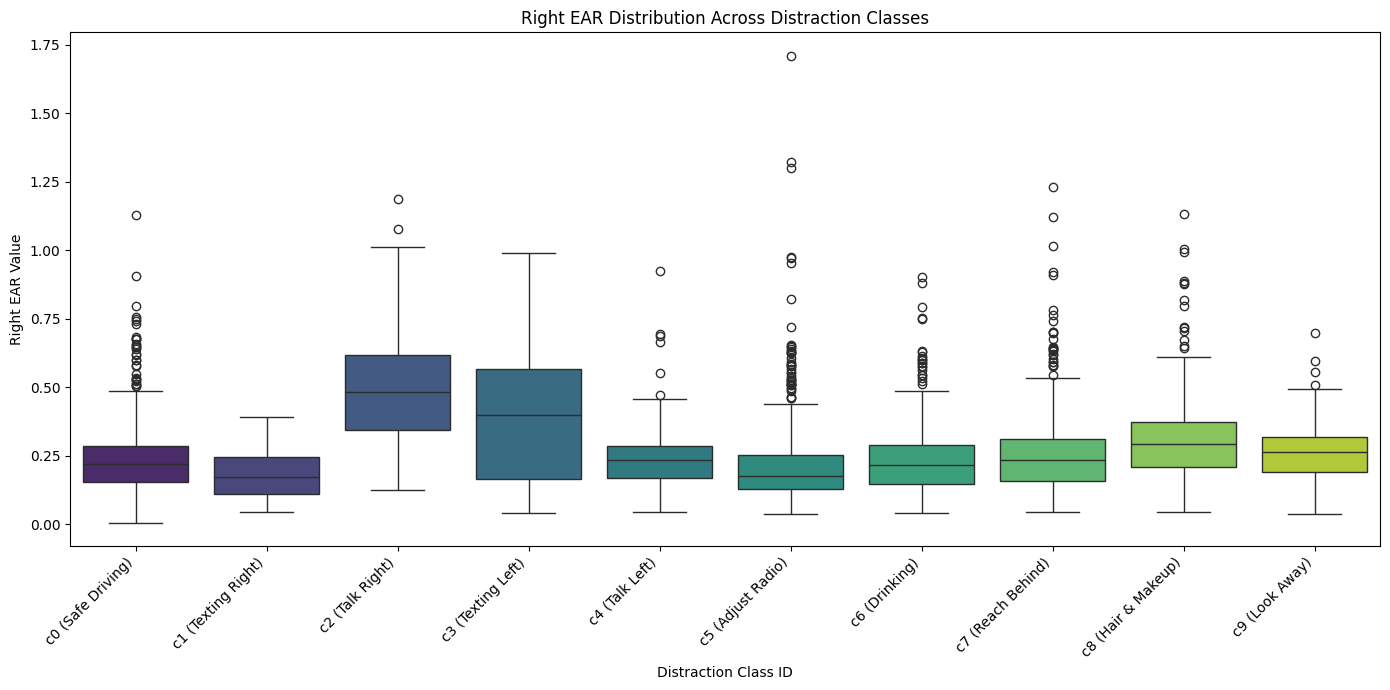


Classifier Model Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,594 (45.29 KB)

 Trainable params: 11,594 (45.29 KB)

 Non-trainable params: 0 (0.00 B)


Training classifier...
Epoch 1/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2952 - loss: 2.0480 - val_accuracy: 0.3568 - val_loss: 1.8406
Epoch 2/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3465 - loss: 1.8711 - val_accuracy: 0.3918 - val_loss: 1.7509
Epoch 3/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3631 - loss: 1.8137 - val_accuracy: 0.3941 - val_loss: 1.7081
Epoch 4/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3781 - loss: 1.7661 - val_accuracy: 0.4098 - val_loss: 1.6727
Epoch 5/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3924 - loss: 1.7398 - val_accuracy: 0.4153 - val_loss: 1.6548
Epoch 6/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3999 - loss: 1.7095 - val_accuracy: 0.4406 - val_loss: 1.6341
Epoch 7/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4063 - loss: 1.6874 - val_accuracy: 0.4346 - val_loss: 1.6145
Epoch 8/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4165 - loss: 1

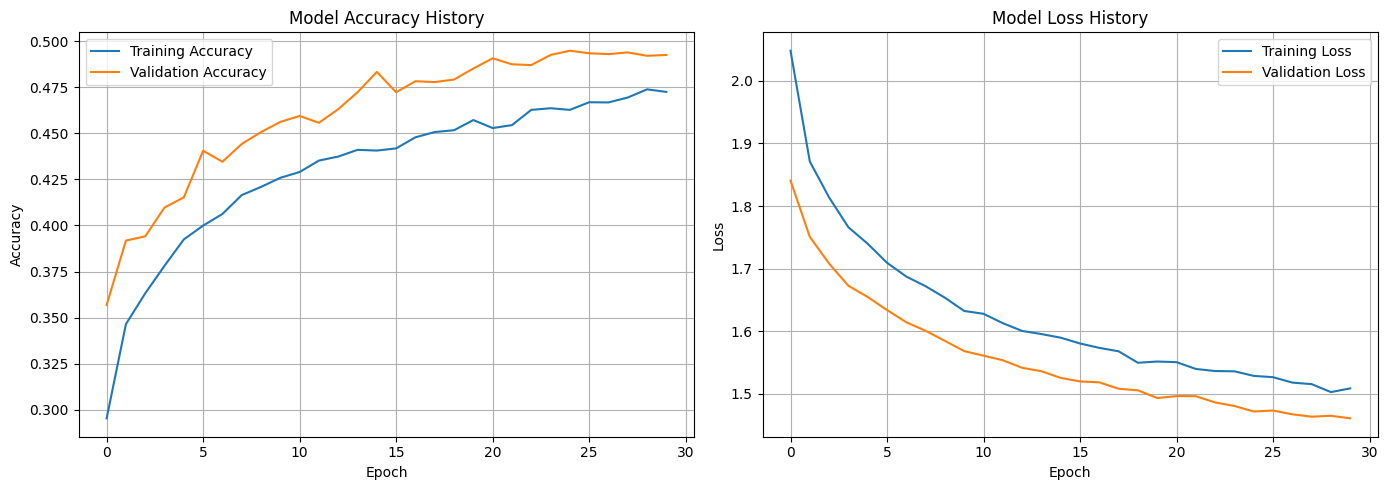


Evaluating final classifier on the test set:
Accuracy on test set: 0.5005

Classification Report:
              precision    recall  f1-score   support

          c0       0.41      0.84      0.56       448
          c1       0.37      0.53      0.43       258
          c2       0.47      0.34      0.39       188
          c3       0.78      0.12      0.22       168
          c4       0.85      0.15      0.25       198
          c5       0.59      0.67      0.63       169
          c6       0.64      0.19      0.29       162
          c7       0.42      0.38      0.40       155
          c8       0.40      0.08      0.13       157
          c9       0.85      0.91      0.88       269

    accuracy                           0.50      2172
   macro avg       0.58      0.42      0.42      2172
weighted avg       0.57      0.50      0.46      2172



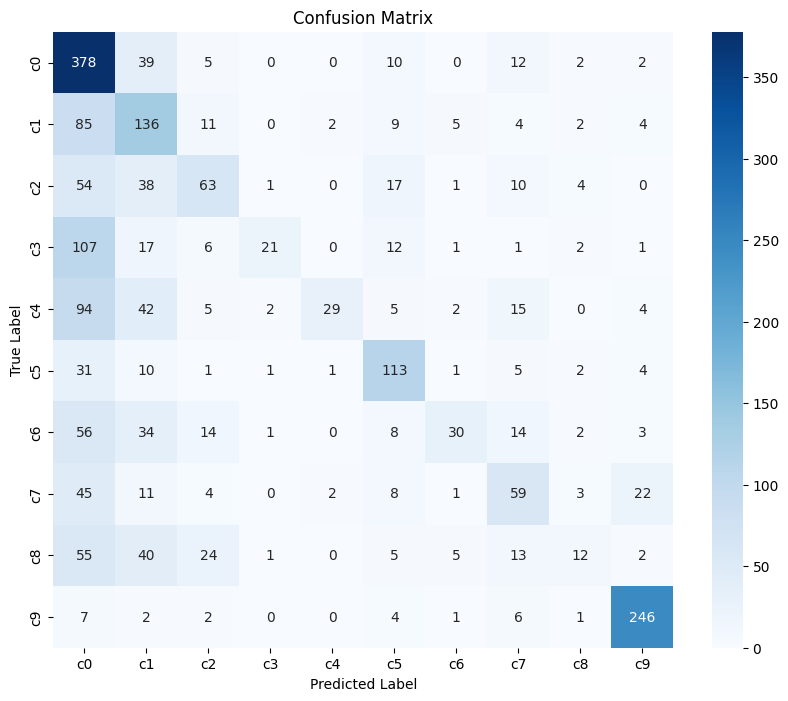

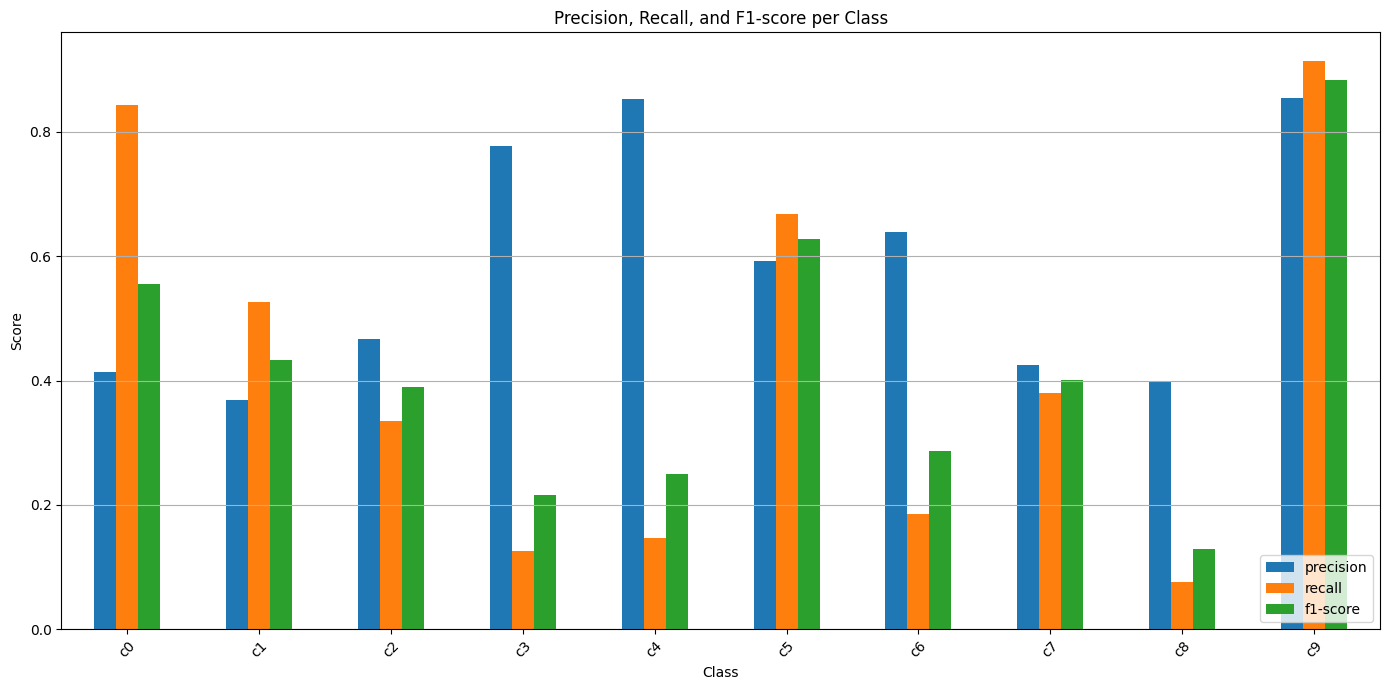

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


# --- Configuration Paths (Adjusted for local Jupyter Notebook) ---
# Get the directory where the current Notebook file is located
# In Jupyter Notebook, os.getcwd() returns the directory of the .ipynb file itself.
BASE_DIR = os.getcwd() 

# Output paths for saving features and labels (Assuming they are in BASE_DIR)
FEATURES_OUTPUT_CSV_PATH = os.path.join(BASE_DIR, 'extracted_features.csv') # No longer _with_cnn
LABELS_OUTPUT_CSV_PATH = os.path.join(BASE_DIR, 'image_labels.csv') # No longer _with_cnn
CLASSIFIER_MODEL_PATH = os.path.join(BASE_DIR, 'final_classifier_model.h5')


# Original class names mapping (for chart labels)
ORIGINAL_CLASS_NAMES = {
    0: 'c0 (Safe Driving)', 1: 'c1 (Texting Right)', 2: 'c2 (Talk Right)',
    3: 'c3 (Texting Left)', 4: 'c4 (Talk Left)', 5: 'c5 (Adjust Radio)',
    6: 'c6 (Drinking)', 7: 'c7 (Reach Behind)', 8: 'c8 (Hair & Makeup)',
    9: 'c9 (Look Away)',
}

print("\n--- Starting final classifier training ---")

# 1. Load Features and Labels
print(f"Loading features from: {FEATURES_OUTPUT_CSV_PATH}")
if not os.path.exists(FEATURES_OUTPUT_CSV_PATH) or not os.path.exists(LABELS_OUTPUT_CSV_PATH):
    print(f"Error: Feature or label CSV files not found. Expected at {FEATURES_OUTPUT_CSV_PATH} and {LABELS_OUTPUT_CSV_PATH}")
    print("Please ensure the feature extraction step completed successfully and files are in the correct location.")
    exit() # Exit if files are not found
else:
    features_df = pd.read_csv(FEATURES_OUTPUT_CSV_PATH)
    labels_df = pd.read_csv(LABELS_OUTPUT_CSV_PATH)

    # X should be all columns of features_df except 'original_class'
    # y should be the 'class_id' from labels_df
    X = features_df.drop(columns=['original_class']).values
    y = labels_df['class_id'].values

    # 2. Split Data: Training, Validation, Test Sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp) # 15% val, 15% test

    print(f"Total samples: {len(X)}")
    print(f"Train samples: {len(X_train)}, Validation samples: {len(X_val)}, Test samples: {len(X_test)}")

    # 3. Feature Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # --- EAR (Eye Aspect Ratio) Analysis ---
    # Filter out samples where person might not be detected or EAR is 0.0 (default failure)
    ear_analysis_df = features_df[(features_df['has_person'] == 1) & (features_df['ear_left'] != 0.0) & (features_df['ear_right'] != 0.0)].copy()

    print("\n--- EAR (Eye Aspect Ratio) Analysis ---")
    if not ear_analysis_df.empty:
        ear_stats = ear_analysis_df.groupby('original_class')[['ear_left', 'ear_right']].agg(['mean', 'std'])
        print("\nEAR Mean and Standard Deviation per Class (excluding 0.0 defaults):")
        print(ear_stats)

        # Plot EAR Distribution (Histograms/KDE)
        plt.figure(figsize=(14, 6))
        plt.subplot(1, 2, 1)
        sns.histplot(ear_analysis_df['ear_left'], kde=True, bins=30, color='skyblue')
        plt.title('Distribution of Left EAR')
        plt.xlabel('EAR Value')
        plt.ylabel('Frequency')

        plt.subplot(1, 2, 2)
        sns.histplot(ear_analysis_df['ear_right'], kde=True, bins=30, color='lightcoral')
        plt.title('Distribution of Right EAR')
        plt.xlabel('EAR Value')
        plt.ylabel('Frequency')
        plt.tight_layout()
        plt.show()

        # Plot EAR Mean per Class (Box plots)
        plt.figure(figsize=(14, 7))
        sns.boxplot(x='original_class', y='ear_left', data=ear_analysis_df, palette='viridis')
        plt.title('Left EAR Distribution Across Distraction Classes')
        plt.xlabel('Distraction Class ID')
        plt.ylabel('Left EAR Value')
        plt.xticks(
            list(ORIGINAL_CLASS_NAMES.keys()),
            list(ORIGINAL_CLASS_NAMES.values()),
            rotation=45, ha='right'
        )
        plt.tight_layout()
        plt.show()
        
        plt.figure(figsize=(14, 7))
        sns.boxplot(x='original_class', y='ear_right', data=ear_analysis_df, palette='viridis')
        plt.title('Right EAR Distribution Across Distraction Classes')
        plt.xlabel('Distraction Class ID')
        plt.ylabel('Right EAR Value')
        plt.xticks(
            list(ORIGINAL_CLASS_NAMES.keys()),
            list(ORIGINAL_CLASS_NAMES.values()),
            rotation=45, ha='right'
        )
        plt.tight_layout()
        plt.show()
    else:
        print("No valid EAR data found for analysis after filtering 0.0 default values.")


    # 4. Build a simple Neural Network Classifier (using Keras)
    num_classes = 10
    input_dim = X_train_scaled.shape[1]

    model_classifier = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])

    model_classifier.compile(optimizer='adam',
                            loss='sparse_categorical_crossentropy',
                            metrics=['accuracy'])

    print("\nClassifier Model Summary:")
    model_classifier.summary()

    # 5. Train the Model
    print("\nTraining classifier...")
    history = model_classifier.fit(X_train_scaled, y_train,
                                   epochs=30, # Changed epochs from 30 to 15
                                   batch_size=32,
                                   validation_data=(X_val_scaled, y_val),
                                   verbose=1)

    # --- Visualize Training History ---
    plt.figure(figsize=(14, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy History')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # 6. Evaluate the Model
    print("\nEvaluating final classifier on the test set:")
    y_pred_probs = model_classifier.predict(X_test_scaled, verbose=0) # Added verbose=0 for cleaner output
    y_pred = np.argmax(y_pred_probs, axis=-1)
    
    print(f"Accuracy on test set: {accuracy_score(y_test, y_pred):.4f}")
    
    print("\nClassification Report:")
    target_names = [f'c{i}' for i in range(num_classes)]
    print(classification_report(y_test, y_pred, target_names=target_names))

    # --- Visualize Confusion Matrix ---
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # --- Visualize Precision, Recall, F1-score per Class ---
    report_dict = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
    
    metrics_df = pd.DataFrame()
    for class_name, metrics in report_dict.items():
        if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
            metrics_df = pd.concat([metrics_df, pd.DataFrame([metrics], index=[class_name])])
    
    metrics_df = metrics_df[['precision', 'recall', 'f1-score']]

    metrics_df.plot(kind='bar', figsize=(14, 7), rot=45)
    plt.title('Precision, Recall, and F1-score per Class')
    plt.xlabel('Class')
    plt.ylabel('Score')
    plt.legend(loc='lower right')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

